In [1]:
from pathlib import Path
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import fastai
from fastai.text import *

In [2]:
DATA_PATH = Path('../data')
tqdm_notebook().pandas()

In [3]:
text_cols = ['title', 'text']

In [4]:
train_df = pd.read_csv(DATA_PATH/'X_train_ftfy_nfkd.csv').fillna('xxempty')
valid_df = pd.read_csv(DATA_PATH/'X_valid_ftfy_nfkd.csv').fillna('xxempty')
test_df = pd.read_csv(DATA_PATH/'X_test_ftfy_nfkd.csv').fillna('xxempty')
unlabeled_df = pd.read_csv(DATA_PATH/'X_unlabeled_ftfy_nfkd.csv').fillna('xxempty')

In [5]:
full_unlabeled_df = pd.concat([train_df['title'], valid_df['title'], test_df['title'], unlabeled_df['title']], 
                              axis=0, ignore_index=True)
full_unlabeled_df.to_csv(DATA_PATH/'full_unlabeled.csv', index=False, header=True)

full_train_df = pd.concat([train_df[['title', 'label']], valid_df[['title', 'label']]], axis=0, ignore_index=True)
full_train_df.to_csv(DATA_PATH/'full_train.csv', index=False, header=True)

test_df['title'].to_csv(DATA_PATH/'full_test.csv', index=False, header=True)

In [6]:
BOS,EOS,FLD,UNK,PAD = 'xxbos','xxeos','xxfld','xxunk','xxpad'
TK_MAJ,TK_UP,TK_REP,TK_WREP = 'xxmaj','xxup','xxrep','xxwrep'
EMPTY = 'xxempty'
text_spec_tok = [UNK,PAD,BOS,EOS,FLD,TK_MAJ,TK_UP,TK_REP,TK_WREP] + [EMPTY]

tokenizer = Tokenizer(special_cases=text_spec_tok)
tokenizer

Tokenizer SpacyTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - replace_all_caps
 - deal_caps

In [21]:
data_lm = TextLMDataBunch.from_csv(DATA_PATH, 'full_unlabeled.csv', 
                                   text_cols='title', bs=32,
                                   tokenizer=tokenizer,
                                   mark_fields=True, include_eos=True, 
                                   min_freq=1, valid_pct=0.1)

In [7]:
# data_lm.save(DATA_PATH/'data_lm_export.pkl')
data_lm = load_data(DATA_PATH, 'data_lm_export.pkl')

In [23]:
data_lm.show_batch()

idx,text
0,"xxmaj new xxmaj york xxmaj times xxeos xxbos xxfld 1 xxmaj sept 24 : xxmaj world xxmaj day xxmaj against xxmaj software xxmaj patents xxeos xxbos xxfld 1 xxmaj even before 2016 is over , the race for 2020 is well underway xxeos xxbos xxfld 1 xxmaj camila xxmaj cabello xxmaj teams xxmaj up xxmaj with j xxmaj balvin & xxmaj pitbull , xxmaj teases xxmaj collab on xxmaj social"
1,"xxbos xxfld 1 xxmaj the xxmaj completely xxmaj insane xxmaj saga of coinbet.cc – xxmaj bitcoin 's latest "" rotten apple "" xxeos xxbos xxfld 1 xxmaj delays xxmaj in xxmaj replacing xxmaj decrepit xxmaj air xxmaj force xxmaj radar xxmaj planes xxmaj could xxmaj prove xxmaj fatal xxmaj to xxup u.s. xxmaj soldiers xxeos xxbos xxfld 1 xxmaj spanish conservative leader xxmaj mariano xxmaj rajoy sworn in as prime"
2,xxmaj stay in xxmaj capital xxmaj after xxmaj brexit - xxmaj bloomberg xxeos xxbos xxfld 1 xxmaj vermont xxmaj man xxmaj accused of xxmaj killing 5 xxmaj teens in xxmaj wrong - xxmaj way xxmaj crash xxmaj pleads xxmaj not xxmaj guilty xxeos xxbos xxfld 1 xxmaj milo xxmaj yiannopoulos says wage gap and gender inequality are conspiracy theories in heated interview with xxmaj cathy xxmaj newman xxeos xxbos xxfld
3,: xxmaj fidel xxmaj castro is dead ! xxeos xxbos xxfld 1 xxmaj it 's a cat - too ! xxmaj russian body artist gives his hairless xxmaj sphynx cat four xxup tattoos after dosing him up with pain killers xxeos xxbos xxfld 1 xxmaj trevor xxmaj noah on election night : xxmaj how can xxmaj america be ' this hateful ' ? - xxmaj business xxmaj insider xxmaj deutschland
4,"xxmaj center xxeos xxbos xxfld 1 xxmaj watford burst xxmaj hull xxmaj city 's hopes thanks to xxmaj michael xxmaj dawson 's late own goal xxeos xxbos xxfld 1 xxmaj paris , xxmaj bill o'reilly , xxmaj venezuela : xxmaj your xxmaj thursday xxmaj evening xxmaj briefing xxeos xxbos xxfld 1 xxmaj is xxmaj this xxmaj pretty xxmaj doll xxmaj spying on xxmaj children ? xxeos xxbos xxfld 1 xxmaj"


In [24]:
len(data_lm.vocab.stoi)

44738

In [25]:
len(data_lm.vocab.itos)

42937

In [26]:
vocab_df = pd.DataFrame(data_lm.vocab.itos, columns=['token'])
vocab_df['token_length'] = vocab_df['token'].str.len()
vocab_df.head()

,token,token_length
0,xxunk,5
1,xxpad,5
2,xxbos,5
3,xxeos,5
4,xxfld,5


In [27]:
vocab_df[vocab_df['token_length'] > 20]['token'].values

array(['videoentry.nbcsports$titleseo', 'oppenheimerfundsvoice', 'obamacareinthreewords', 'veteransforkaepernick',
       'ゲス財布特集_人気春夏新作は50%offで通販_送料無料', 'dogsatpollingstations', 'hairloss&care|hairtransplantation|remedies',
       'hairloss|lasertreatment', '—@uma.balachandran.927', 'watch-ブランド腕時計、時計買取-販売専門店', 'trumpscomingchallenge',
       "day'(2011)'online'megavideo", 'pricewaterhousecoopers', 'watchonlinemegavideofree',
       'dns_amplification_refletion_attack'], dtype=object)

In [28]:
dup_df = full_train_df[full_train_df.duplicated(keep=False)].sort_values('title').head()
dup_df

,title,label
5105,'Greatest threat to democracy': Commander of b...,news
8955,'Greatest threat to democracy': Commander of b...,news
9020,'Hollywood' sign changed to 'Hollyweed' in new...,news
10801,'Hollywood' sign changed to 'Hollyweed' in new...,news
1812,10 things you need to know before the opening ...,clickbait


In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


0.03981071705534973

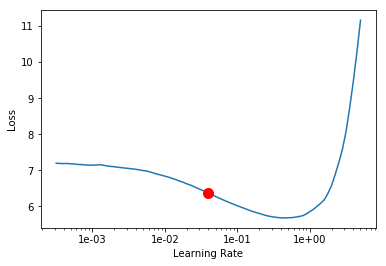

In [31]:
learn.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn.recorder.plot(suggestion=True)

best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

In [32]:
learn.fit_one_cycle(1, best_lm_lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.833049,3.544683,0.482348,03:46


In [33]:
learn.save('lm_freezed_2')
learn.save_encoder('lm_enc_freezed_2')

In [34]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.16E-04


0.00031622776601683783

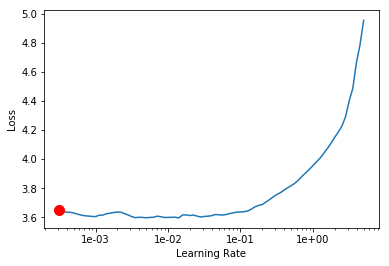

In [35]:
learn.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn.recorder.plot(suggestion=True)

best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

In [36]:
learn.fit_one_cycle(1, best_lm_lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.395707,3.357138,0.497466,04:29


In [37]:
learn.save('lm_unfreezed_2')
learn.save_encoder('lm_enc_unfreezed_2')

In [9]:
data_clas = TextClasDataBunch.from_csv(path=DATA_PATH, 
                                       csv_name='full_train.csv',
                                       test='full_test.csv',
                                       vocab=data_lm.train_ds.vocab, 
                                       bs=32,
                                       text_cols='title', 
                                       label_cols='label',
                                       tokenizer=tokenizer,
                                       mark_fields=True, include_eos=True, 
                                       min_freq=1, valid_pct=0.1)

In [15]:
# data_clas.save(DATA_PATH/'data_clas_export.pkl')
data_clas = load_data(DATA_PATH, 'data_clas_export.pkl', bs=32)

In [39]:
data_clas.show_batch()

text,target
"xxbos xxfld 1 xxmaj top stories xxmaj top stories xxmaj theresa xxmaj may delays triggering xxmaj article 50 ' xxmaj politics is not a game ' : xxmaj may attacks xxmaj sturgeon over referendum call xxmaj trump does n't believe xxmaj obama wiretapped him ' personally ' xxmaj turkish president claims xxmaj germany ' mercilessly supports terrorism ' xxmaj subscribe to the xxmaj daily xxmaj edition , our newspaper for",clickbait
"xxbos xxfld 1 xxmaj sections xxmaj shows xxmaj live yahoo!-abc xxmaj news xxmaj network | © 2017 xxup abc xxmaj news xxmaj internet xxmaj ventures . xxmaj all rights reserved . xxup abc xxmaj news xxmaj police ' xxmaj do n't xxmaj know ' xxmaj where xxmaj escaped xxmaj killers xxmaj have xxmaj gone , xxmaj new xxmaj york xxmaj governor xxmaj says xxmaj police ' xxmaj do n't xxmaj",clickbait
xxbos xxfld 1 xxmaj patricia xxmaj smith : xxmaj hillary xxmaj clinton ' xxmaj treats xxmaj me xxmaj like xxmaj dirt ' xxmaj because ' i 'm a xxmaj nobody ' -- ' xxmaj why xxmaj does n't xxmaj she xxmaj just xxmaj tell xxmaj me the xxmaj truth ? ' xxeos,news
"xxbos xxfld 1 xxmaj the xxup isis mafia : xxmaj how xxmaj syrian businessmen are forced to hand over sums of up to $ 100,000 to xxmaj islamic xxmaj state thugs on top of trumped - up taxes ... or risk trying to run businesses in chaotic rebel - held areas xxeos",news
xxbos xxfld 1 xxmaj russian ' special squadron ' plane arrives to evacuate 35 of xxmaj putin 's ' spies ' from the xxup us as it emerges one of them is a consulate xxup chef and embassy staff call xxmaj obama 's last - gasp expulsion ' ridiculous ' xxeos,news


In [40]:
len(data_clas.vocab.stoi)

44738

In [41]:
len(data_clas.vocab.itos)

42937

In [42]:
vocab_df = pd.DataFrame(data_clas.vocab.itos, columns=['token'])
vocab_df['token_length'] = vocab_df['token'].str.len()
vocab_df.head()

,token,token_length
0,xxunk,5
1,xxpad,5
2,xxbos,5
3,xxeos,5
4,xxfld,5


In [43]:
vocab_df[vocab_df['token_length'] > 20]['token'].values

array(['videoentry.nbcsports$titleseo', 'oppenheimerfundsvoice', 'obamacareinthreewords', 'veteransforkaepernick',
       'ゲス財布特集_人気春夏新作は50%offで通販_送料無料', 'dogsatpollingstations', 'hairloss&care|hairtransplantation|remedies',
       'hairloss|lasertreatment', '—@uma.balachandran.927', 'watch-ブランド腕時計、時計買取-販売専門店', 'trumpscomingchallenge',
       "day'(2011)'online'megavideo", 'pricewaterhousecoopers', 'watchonlinemegavideofree',
       'dns_amplification_refletion_attack'], dtype=object)

In [44]:
dup_df = full_train_df[full_train_df.duplicated(keep=False)].sort_values('title').head()
dup_df

,title,label
5105,'Greatest threat to democracy': Commander of b...,news
8955,'Greatest threat to democracy': Commander of b...,news
9020,'Hollywood' sign changed to 'Hollyweed' in new...,news
10801,'Hollywood' sign changed to 'Hollyweed' in new...,news
1812,10 things you need to know before the opening ...,clickbait


In [16]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
learn_clas.load_encoder('lm_enc_unfreezed_2')

RuntimeError: Error(s) in loading state_dict for AWD_LSTM:
	size mismatch for encoder.weight: copying a param with shape torch.Size([42937, 400]) from checkpoint, the shape in current model is torch.Size([26079, 400]).
	size mismatch for encoder_dp.emb.weight: copying a param with shape torch.Size([42937, 400]) from checkpoint, the shape in current model is torch.Size([26079, 400]).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-03


0.0015848931924611136

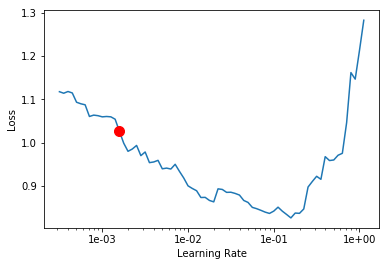

In [46]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [47]:
learn_clas.fit_one_cycle(1, best_clf_lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.691263,0.433123,0.819909,00:32


In [48]:
learn_clas.save('clf_freezed_2')

In [49]:
learn_clas.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04


0.0003981071705534973

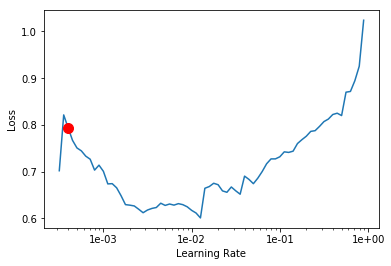

In [50]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [51]:
learn_clas.fit_one_cycle(1, slice(best_clf_lr/2.6**4, best_clf_lr), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.548898,0.423965,0.829406,00:38


In [52]:
learn_clas.save('clf_unfreezed_2_2')

In [14]:
learn_clas = learn_clas.load('clf_unfreezed_2_2')

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	size mismatch for 0.module.encoder.weight: copying a param with shape torch.Size([42937, 400]) from checkpoint, the shape in current model is torch.Size([26079, 400]).
	size mismatch for 0.module.encoder_dp.emb.weight: copying a param with shape torch.Size([42937, 400]) from checkpoint, the shape in current model is torch.Size([26079, 400]).

In [55]:
learn_clas.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.16E-04


0.000316227766016838

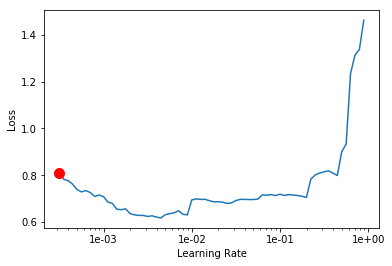

In [56]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [57]:
learn_clas.fit_one_cycle(1, slice(best_clf_lr/2.6**4, best_clf_lr), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 7.43 GiB total capacity; 5.43 GiB already allocated; 21.94 MiB free; 172.39 MiB cached)

In [28]:
learn_clas.save('clf_unfreezed_all_2')

In [29]:
learn_clas.show_results()

text,target,prediction
xxbos xxmaj sections xxmaj shows xxmaj live yahoo!-abc xxmaj news xxmaj network | © 2017 xxup abc xxmaj news xxmaj internet xxmaj ventures . xxmaj all rights reserved . xxup abc xxmaj news xxmaj video xxmaj shows xxmaj patient xxmaj playing xxmaj guitar xxmaj during xxmaj brain xxmaj surgery in xxmaj brazil xxmaj amazing xxmaj video xxmaj shows xxmaj patient xxmaj playing xxmaj guitar xxmaj during xxmaj brain xxmaj surgery,news,news
xxbos xxmaj sections xxmaj shows xxmaj live yahoo!-abc xxmaj news xxmaj network | © 2017 xxup abc xxmaj news xxmaj internet xxmaj ventures . xxmaj all rights reserved . xxup abc xxmaj news xxmaj passengers on xxmaj diverted xxmaj flight xxmaj stuck xxmaj almost 24 xxmaj hours in xxmaj canada xxmaj passengers on xxmaj diverted xxmaj flight xxmaj stuck xxmaj almost 24 xxmaj hours in xxmaj canada + xxmaj dad,news,news
"xxbos xxmaj sections xxmaj shows xxmaj live yahoo!-abc xxmaj news xxmaj network | © 2017 xxup abc xxmaj news xxmaj internet xxmaj ventures . xxmaj all rights reserved . xxup abc xxmaj news xxmaj police ' xxmaj do n't xxmaj know ' xxmaj where xxmaj escaped xxmaj killers xxmaj have xxmaj gone , xxmaj new xxmaj york xxmaj governor xxmaj says xxmaj police ' xxmaj do n't xxmaj know '",clickbait,news
"xxbos xxmaj sections xxmaj shows xxmaj live yahoo!-abc xxmaj news xxmaj network | © 2017 xxup abc xxmaj news xxmaj internet xxmaj ventures . xxmaj all rights reserved . xxup abc xxmaj news xxmaj james xxmaj holmes xxmaj took xxmaj first xxmaj love to xxmaj horror xxmaj movie xxmaj fest , xxmaj she xxmaj testifies in xxmaj aurora xxmaj trial xxmaj james xxmaj holmes xxmaj took xxmaj first xxmaj love",news,news
xxbos xxmaj sections xxmaj shows xxmaj live yahoo!-abc xxmaj news xxmaj network | © 2017 xxup abc xxmaj news xxmaj internet xxmaj ventures . xxmaj all rights reserved . xxup abc xxmaj news xxmaj transgender xxmaj teen xxmaj sues xxmaj virginia xxmaj school xxmaj board for xxmaj allegedly xxmaj not xxmaj allowing xxmaj him to xxmaj use xxmaj boys xxmaj room xxmaj transgender xxmaj teen xxmaj sues xxmaj school xxmaj,clickbait,news


In [40]:
test_preds = []

for batch in tqdm_notebook(learn_clas.data.test_dl):
    test_preds.append(learn_clas.pred_batch(batch))
    
len(test_preds)

353

In [67]:
test_pred_df = pd.DataFrame(torch.cat(test_preds), columns=['clickbait', 'news', 'other'])
ulmfit_preds = pd.Series(np.argmax(test_pred_df.values, axis=1),
                        name='label').map({0: 'clickbait', 1: 'news', 2: 'other'})

In [48]:
ulmfit_preds.to_csv('ulmfit_predictions_title.csv', index_label='id', header=True)

In [49]:
!head 'ulmfit_predictions_title.csv'

id,label
0,news
1,news
2,news
3,news
4,news
5,news
6,news
7,news
8,news


In [50]:
!wc -l ulmfit_predictions_title.csv

5649 ulmfit_predictions_title.csv


In [42]:
!kaggle competitions submit -c dlinnlp-spring-2019-clf -f ulmfit_predictions_title.csv -m "ULMFiT Baseline"

100%|██████████████████████████████████████| 56.9k/56.9k [00:05<00:00, 11.3kB/s]
Successfully submitted to DL in NLP Spring 2019. Classification